# Style Transfer based on CNN

## Basic Functions import


In [1]:
# Import libraries (all pre-installed in Colab)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# Device setup (uses Colab's GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load and preprocess image
def load_image(image_path, size=256):
  image = Image.open(image_path).convert('RGB')
  transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
  ])
  return transform(image).unsqueeze(0).to(device)

# Function to display image in Colab
def show_image(tensor, title=None):
  image = tensor.cpu().detach().squeeze(0).numpy().transpose(1, 2, 0).clip(0, 1)
  plt.imshow(image)
  if title:
      plt.title(title)
  plt.axis('off')
  plt.show()


In [2]:
class VGG(nn.Module):
    def __init__(self, mode='single_style'):
        super(VGG, self).__init__()
        self.mode = mode  # 'single_style' or 'multi_style'

        # Load pretrained VGG19 and freeze weights
        vgg = models.vgg19(pretrained=True).features.to(device)
        for param in vgg.parameters():
            param.requires_grad_(False)

        # Common layers for both modes
        self.content_layer = '21'  # conv4_2
        self.style_layers = ['0', '5', '10']  # conv1_1, conv2_1, conv3_1

        # Build model based on mode
        if mode == 'single_style':
            # For original style_transfer (returns dict of features)
            self.model = nn.Sequential()
            for i, layer in enumerate(vgg):
                if i > 21:  # Stop after conv4_2
                    break
                self.model.add_module(str(i), layer)
        else:
            # For multi_style_transfer (returns tuple: content, style)
            self.content_model = nn.Sequential(*list(vgg.children())[:22])  # Up to conv4_2
            self.style_model = nn.Sequential(*list(vgg.children())[:5])     # Up to conv2_1

    def forward(self, x):
        if self.mode == 'single_style':
            # Original style_transfer compatibility
            features = {}
            for name, layer in self.model.named_children():
                x = layer(x)
                if name == self.content_layer:
                    features['content'] = x
                if name in self.style_layers:
                    features[name] = x
            return features
        else:
            # Multi-style transfer compatibility
            content = self.content_model(x)
            style = self.style_model(x)
            return content, style


def gram_matrix(tensor):
    """ Unified Gram matrix calculation for both modes """
    if len(tensor.size()) == 4:  # Batch mode
        _, c, h, w = tensor.size()
        tensor = tensor.view(c, h * w)
    else:  # Already squeezed (multi-style case)
        c, h, w = tensor.size(1), tensor.size(2), tensor.size(3)
        tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

## Transfer based on the Single Style

In [3]:
# Style transfer function
def style_transfer(content_img, style_img, steps=400):
    model = VGG(mode='single_style').to(device)

    with torch.no_grad():
        content_features = model(content_img)
        style_features = model(style_img)

    input_img = content_img.clone().requires_grad_(True)
    optimizer = optim.Adam([input_img], lr=0.01)

    for step in range(steps):
        optimizer.zero_grad()

        input_features = model(input_img)

        content_loss = torch.mean((input_features['content'] - content_features['content']) ** 2)

        style_loss = 0
        for layer in model.style_layers:
            input_gram = gram_matrix(input_features[layer])
            style_gram = gram_matrix(style_features[layer])
            style_loss += torch.mean((input_gram - style_gram) ** 2)
        style_loss /= len(model.style_layers)

        total_loss = content_loss + 1000 * style_loss
        total_loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step {step}, Total Loss: {total_loss.item():.4f}")
            show_image(input_img, f"Step {step}")

    return input_img

Upload your content image:


Saving c1.jpg to c1.jpg
Upload your style image:


Saving s1.jpg to s1.jpg
Content Image:


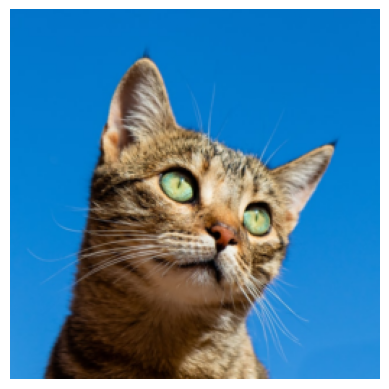

Style Image:


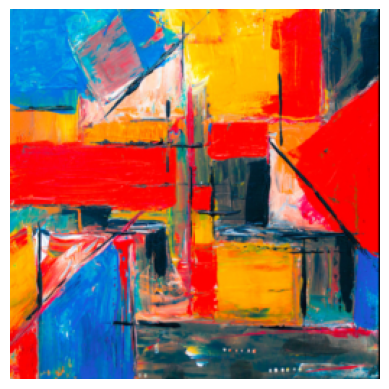

Running style transfer...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 81.0MB/s]


Step 0, Total Loss: 14794138624.0000


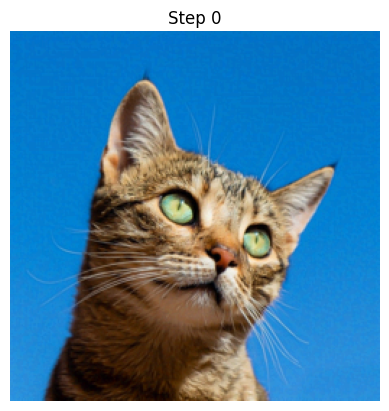

Step 50, Total Loss: 1652177792.0000


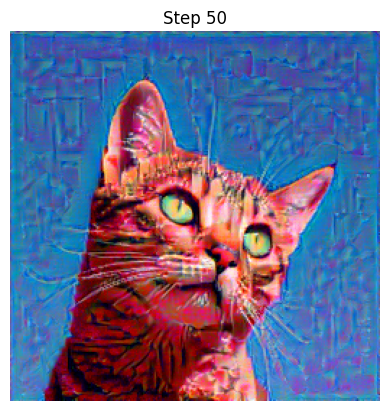

Step 100, Total Loss: 563001728.0000


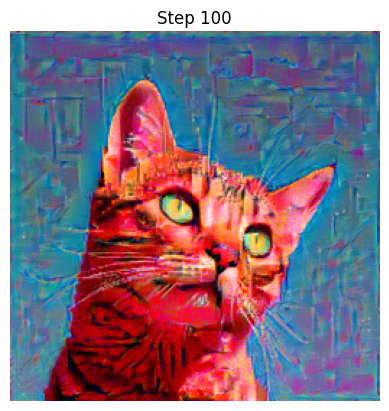

Step 150, Total Loss: 270006848.0000


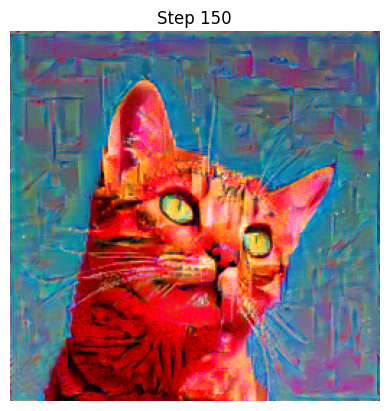

Step 200, Total Loss: 156049376.0000


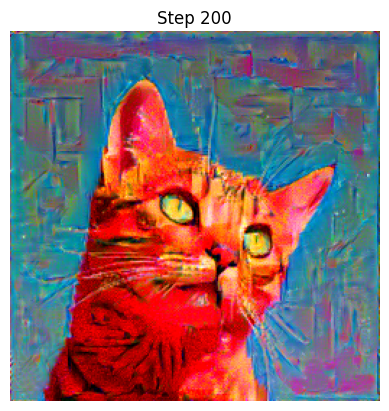

Step 250, Total Loss: 106541200.0000


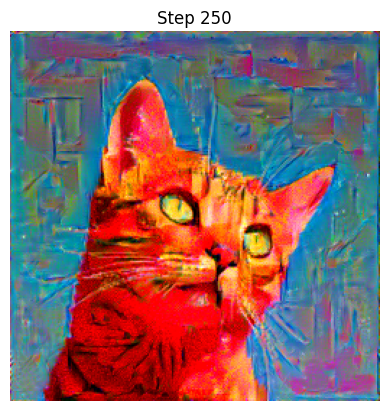

Step 300, Total Loss: 80447552.0000


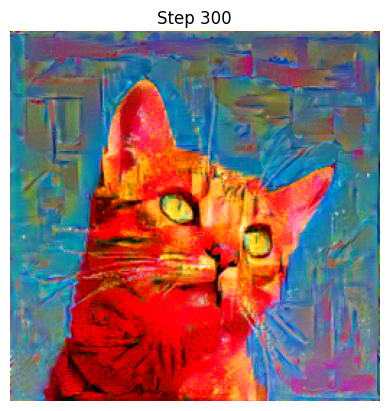

Step 350, Total Loss: 63953552.0000


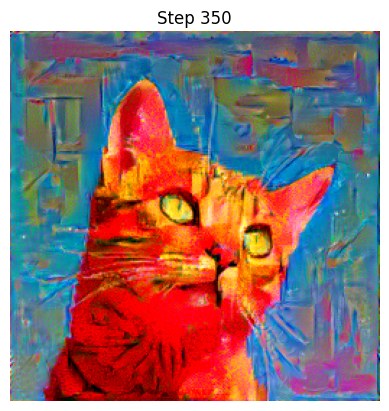

Final Output:


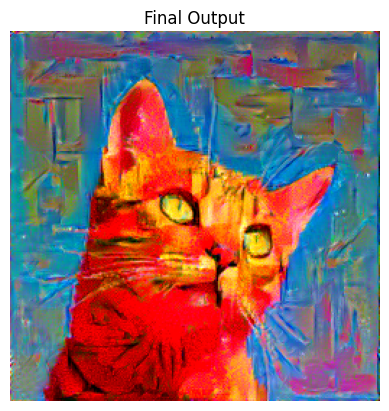

In [4]:
# Upload content and style images in Colab
print("Upload your content image:")
content_upload = files.upload()
content_path = list(content_upload.keys())[0]
content_img = load_image(content_path)

print("Upload your style image:")
style_upload = files.upload()
style_path = list(style_upload.keys())[0]
style_img = load_image(style_path)

# Show original images
print("Content Image:")
show_image(content_img)
print("Style Image:")
show_image(style_img)

# Run style transfer
print("Running style transfer...")
result = style_transfer(content_img, style_img)

# Show and save final result
print("Final Output:")
show_image(result, "Final Output")

**Transfer based on Multi Style**

In [5]:
# Multi-style transfer
def multi_style_transfer(content_img, style_imgs, weights, steps=400):
    model = VGG(mode='multi_style').to(device)

    with torch.no_grad():
        content_target, _ = model(content_img)
        style_targets = [model(style_img)[1] for style_img in style_imgs]
        style_grams = [gram_matrix(style) for style in style_targets]

    input_img = content_img.clone().requires_grad_(True)
    optimizer = optim.Adam([input_img], lr=0.01)

    for step in range(steps):
        optimizer.zero_grad()

        content_output, style_output = model(input_img)

        content_loss = torch.mean((content_output - content_target) ** 2)

        input_gram = gram_matrix(style_output)
        fused_gram = sum(w * sg for w, sg in zip(weights, style_grams))
        style_loss = torch.mean((input_gram - fused_gram) ** 2)

        total_loss = content_loss + 1000 * style_loss
        total_loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step {step}, Loss: {total_loss.item():.4f}")
            show_image(input_img)

    return input_img

Upload content image:


Saving c1.jpg to c1.jpg
Upload first style image:


Saving s1.jpg to s1.jpg
Upload second style image:


Saving s2.jpg to s2.jpg


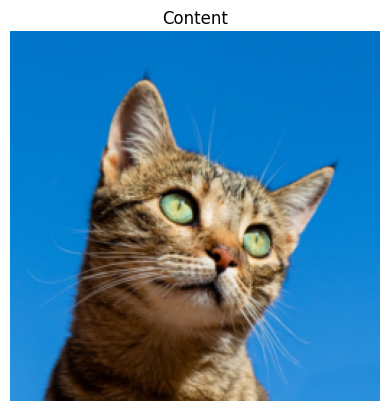

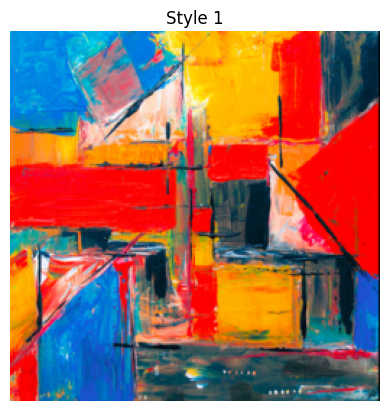

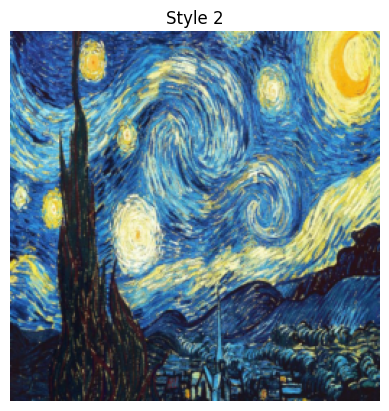

Step 0, Loss: 43126136832.0000


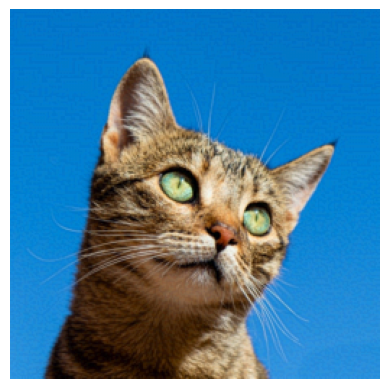

Step 50, Loss: 1675088512.0000


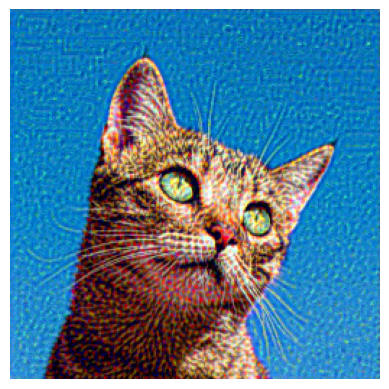

Step 100, Loss: 597722624.0000


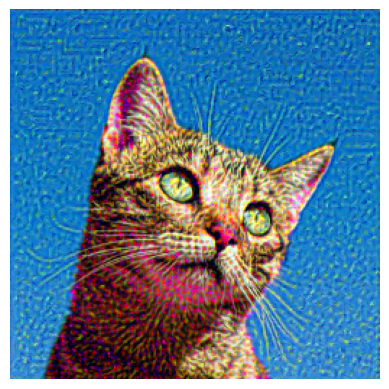

Step 150, Loss: 271013824.0000


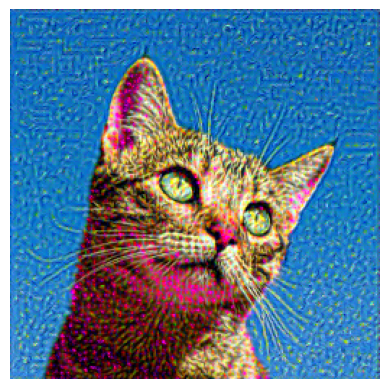

Step 200, Loss: 167289328.0000


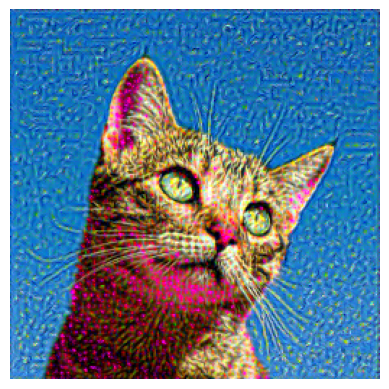

Step 250, Loss: 119015720.0000


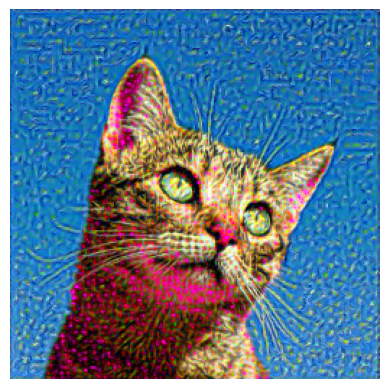

Step 300, Loss: 89893160.0000


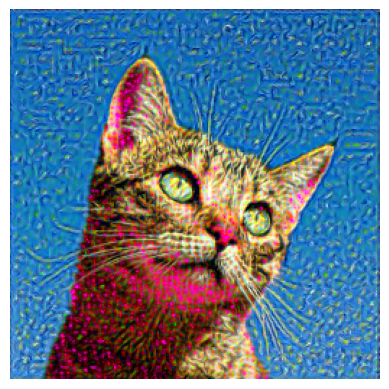

Step 350, Loss: 70373992.0000


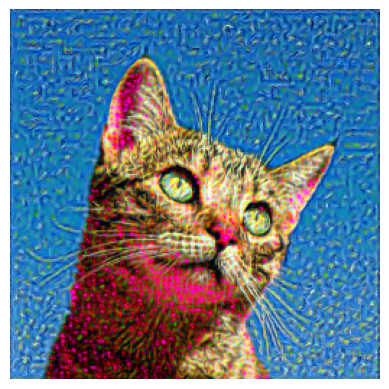

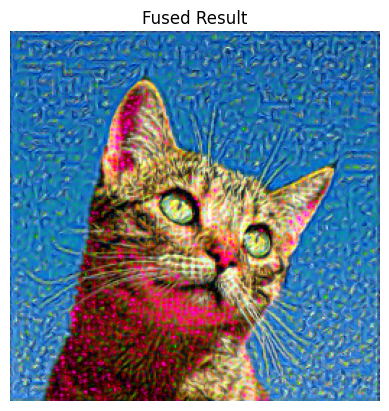

In [6]:
# Upload images
print("Upload content image:")
content_upload = files.upload()
content_img = load_image(list(content_upload.keys())[0])

print("Upload first style image:")
style1_upload = files.upload()
style1_img = load_image(list(style1_upload.keys())[0])

print("Upload second style image:")
style2_upload = files.upload()
style2_img = load_image(list(style2_upload.keys())[0])

# Show originals
show_image(content_img, "Content")
show_image(style1_img, "Style 1")
show_image(style2_img, "Style 2")

# Run with 50-50 fusion
weights = [0.5, 0.9]  # Equal blend
result = multi_style_transfer(content_img, [style1_img, style2_img], weights)

# Show and save result
show_image(result, "Fused Result")

## Style Transfer based on CLIP and Diffusion model

In [ ]:
# Install the Stable Diffusion libraray from the Hugging Face
!pip install diffusers transformers

# Install CLIP
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-49m7ttld
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-49m7ttld
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

`StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")`:

Loads the pre-trained Stable Diffusion model (v1-5), designed for image-to-image transformations.

`clip.load("ViT-B/32", device=device)`:

Loads the CLIP model (ViT-B/32 version) to understand the semantic relationship between text prompts (e.g., Van Gogh style) and images.

`prompt = "A painting of a tree in the style of Van Gogh, swirling brushstrokes, vibrant colors": `

Defines the target style, describing Van Gogh’s swirling brushstrokes and vibrant colors.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Upload content image:


Saving tree.jpg to tree.jpg


  0%|          | 0/37 [00:00<?, ?it/s]

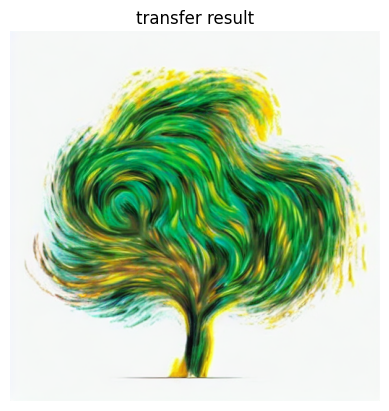

In [8]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
import clip
from PIL import Image

# Load the Stable Diffusion model
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to(device)

# Load the CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Load the original image
# init_image = Image.open("tree.jpg").convert("RGB").resize((512, 512))
print("Upload content image:")
init_image_upload = files.upload()
init_image = load_image(list(init_image_upload.keys())[0], size=512)

# Define the style prompt
prompt = "A painting of a tree in the style of Van Gogh, swirling brushstrokes, vibrant colors"

# Perform image style transfer using Stable Diffusion
generator = torch.Generator(device=device).manual_seed(42)  # Set a fixed seed for reproducibility
result = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.75,  # Controls the strength of the style transfer (0.0–1.0, higher means more change)
    guidance_scale=7.5,  # Controls how strongly the prompt influences the result
    generator=generator
)

# Display the result instead of saving
output_image = result.images[0]
# output_image.show()
plt.imshow(output_image)
plt.title("transfer result")
plt.axis('off')
plt.show()